In [ ]:
# GENERATE FILE FOR probeTm.py WITH TWO COLUMNS: SEQUENCE NUBMER AND PROBE SEQUENCE #
read_filename = 'data/mouse_chr6/rosa26_probes_sC.bed'
write_filename = 'data/mouse_chr6/rosa26_probes_TM.txt'

# read file output from structureCheck.py #
with open(read_filename) as file:
    probes = [(k+1, line.split('	')[3]) for k, line in enumerate(file)]

# write to new file for input to probeTm.py #
with open(write_filename, 'w') as file:
    for probe in probes:
        # file.write(f'{probe[0]}\t{probe[1]}\n')
        pass

In [4]:
from duplex_prob import filter_duplex_prob

sam_file = 'data/target_seqs/rosa26_against_full/rosa26.sam'
bed_file = 'data/target_seqs/rosa26_against_full/rosa26_probes_sC.bed'

filter_duplex_prob(sam_file, bed_file, filter_temp=37, filter_prob=0.4)

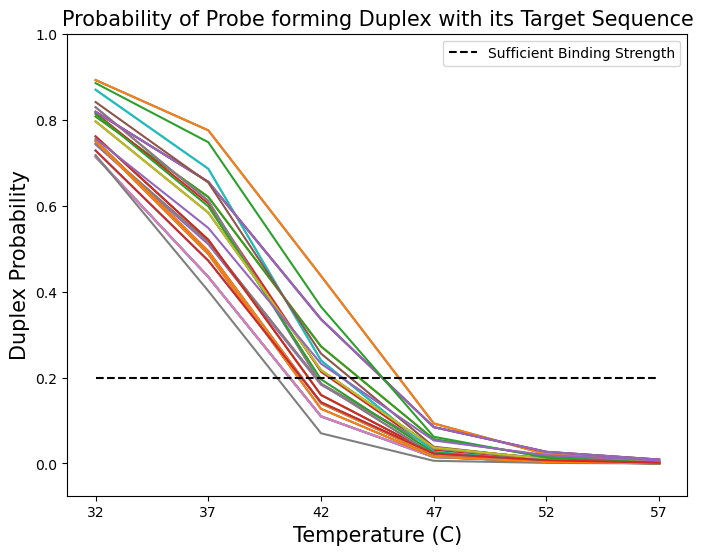

In [5]:
# PLOTTING RESULTS FROM duplex_prob.py #
from duplex_prob import plot_duplex_prob

filtered_filename = 'data/target_seqs/rosa26_against_full/rosa26_probes_sC_filtered.bed'

###################################################################################################

plot_duplex_prob(filtered_filename)